#### Aim: To aggregate the results based on large number of configurations possible with ChipSats

In [1]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
from numba import jit


In [2]:
@jit(nopython =True)

def src_Loc(rec_pos, t_rec,c,src_pos):
    '''The function returns the difference between the position of source(guessed) and receiver location as calculated from 
    measurement of time difference of arrival with the distance calculated from position of source and receiver. We aim to 
    minimise this quantity

    rec_pos = a matrix with position of receivers stored in the following format [[x_1, y_1],[x_2,y_2]]
    t_rec  = the time of arrival as measured from data
    source_loc = the guessed source location for which the function is being evaluated
    
    '''
    
    n_rec = np.shape(rec_pos)[0]
    t_rec_rel1 = np.zeros(shape=(n_rec-1,1))   # time difference calculated wrt the value in first receiver
    
    t_rec_rel1[:] = t_rec[1:] -t_rec[0]     
    
    rec_pos_src_rel = np.zeros(shape =(n_rec-1,2)) # Calculating the relative position of recivers wrt the source
    
    rec_pos_src_rel[:] = rec_pos[1:] -src_pos*np.ones_like(rec_pos_src_rel)  # relative position of receiver 1 wrt the source
    
    rec1_pos_src_rel = rec_pos[0] -src_pos # the position of receiver one wrt the source
    
    rec_dist_src_rel = np.zeros(shape=(n_rec-1,1))
    
    rec1_dist_src_rel = np.sqrt(rec1_pos_src_rel[0]**2 + rec1_pos_src_rel[1]**2)
    
    rec_dist_src_rel[:] = np.sqrt(rec_pos_src_rel[:,0]**2 + rec_pos_src_rel[:,1]**2).reshape(n_rec-1,1)
    
    delta_r = t_rec_rel1*c
    
    error = np.zeros(shape =(n_rec-1,1))   # defing the error to be minimized
    error[:] = delta_r[:] - (rec_dist_src_rel[:]-rec1_dist_src_rel)   
    
    error_to_min =np.dot(error.T,error) # Getting a single value instead of an array
    
    return error_to_min
        

In [3]:
# Testing out with 101 receivers placed in a line

rec_pos_act= np.zeros(shape =(101,2))  # Assigning thr actual receiver position
rec_pos_act[:,:] = 0 # The deployer is at origin. 
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
t_rec_ideal = np.zeros(shape =(101,1))  # ideal value at receivers
rec_pos_mes= rec_pos_act +noise_r   
t_rec_ideal[0:101] = (np.sqrt((rec_pos_mes[0:101,1]-100)**2 + (rec_pos_mes[0:101,0]-100)**2).reshape(101,1))/1000
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (101,1))
t_Rec_real = t_rec_ideal + noise_t

c = 1 # velocity of propagation

# Note the different order in which the noises are added this time. 

Text(0.5, 1.0, 'Error contour for receivers with error in both time of arrival and known position')

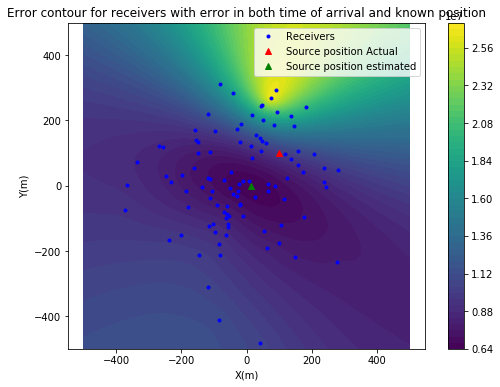

In [4]:
# Now evaluating the function at various points in 2D

x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
error = np.zeros(shape=(1000,1000))  # To store the values at various points
rec_pos_modified = np.zeros_like(rec_pos_act)
noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
rec_pos_modified[:] = rec_pos_mes[:] + noise_r  # Can modify later if required
for i in range(1000):
    for j in range(1000):
        error[i,j] = src_Loc(rec_pos=rec_pos_modified,t_rec=t_Rec_real,c=c*1000,src_pos=np.array([x[i,j],y[i,j]]))
plt.figure(figsize=(8,6))
plt.contourf(x,y,error,levels=50)
plt.plot(rec_pos_modified[:,0],rec_pos_modified[:,1],'b.',label='Receivers')
plt.plot(100,100,'r^',label='Source position Actual')
plt.plot(x[np.where(error == np.min(error))],y[np.where(error == np.min(error))],'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')
plt.colorbar()
plt.title('Error contour for receivers with error in both time of arrival and known position')

In [6]:
error_in_source = np.zeros(1000)
#@jit(nopython =True)
for k in range(1000):
    # Testing out with 101 receivers placed in a line

    rec_pos_act= np.zeros(shape =(101,2))  # Assigning thr actual receiver position
    rec_pos_act[:,:] = 0 # The deployer is at origin. 
    c = 1000 # velocity of propagation

    noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
    t_rec_ideal = np.zeros(shape =(101,1))  # ideal value at receivers
    rec_pos_mes= rec_pos_act +noise_r   
    t_rec_ideal[0:101] = (np.sqrt((rec_pos_mes[0:101,1]-100)**2 + (rec_pos_mes[0:101,0]-100)**2).reshape(101,1))/c
    noise_t = np.random.normal(loc=0.0,scale =0.2,size = (101,1))
    t_Rec_real = t_rec_ideal + noise_t
    
    x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position
    error = np.zeros(shape=(1000,1000))  # To store the values at various points
    rec_pos_modified = np.zeros_like(rec_pos_act)
    noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
    rec_pos_modified[:] = rec_pos_mes[:] + noise_r  # Can modify later if required
    for i in range(1000):
        for j in range(1000):
            error[i,j] = src_Loc(rec_pos=rec_pos_modified,t_rec=t_Rec_real,c=c*1000,src_pos=np.array([x[i,j],y[i,j]]))
    error_in_source[k] = (x[np.where(error == np.min(error))] - 100)**2 + (y[np.where(error == np.min(error))]-100)**2
    
    
# Note the different order in which the noises are added this time. 

KeyboardInterrupt: 

Text(0.5, 1.0, 'Histogram of error produced by multiple runs involving both time and location error')

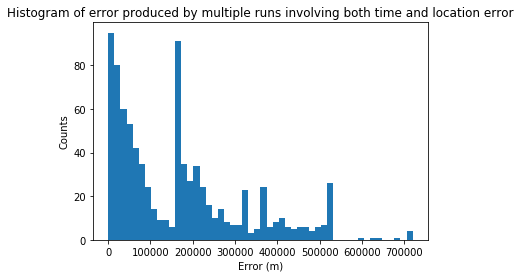

In [8]:
plt.hist(error_in_source[error_in_source  > 0.0],bins =50);
plt.xlabel('Error (m)')
plt.ylabel('Counts')
plt.title('Histogram of error produced by multiple runs involving both time and location error')